# ChatGPT User Reviews: EDA

**Problem Statement**: To enhance the customer experience for (online) products, this project will analyze user reviews on ChatGPT from the iOS store. By leveraging NLP techniques, I aim to classify overall sentiment, extract product-related feedback and identify trends in user satisfaction. Insights from this analysis will inform actionable recommendations to improve a product’s usability, functionality and overall satisfaction.

**Overview:** In this section, I hope to use EDA to be able to better understand the distribution of the data. Some questions I would like to be able to answer are what are the most popular features? Is the app being rated positively or negatively overall? Do users' like certain features or do they dislike certain features? By visualizing the data, I hope to better understand the reviews and how they are being distributed. I am hoping that these insights will help businesses to see where users have the most positive feedback and where they feel the product is lacking the most.   

**Sources:**
> https://www.analyticsvidhya.com/blog/2021/10/sentiment-analysis-with-textblob-and-vader/#:~:text=VADER%2C%20like%20TextBlob%2C%20is%20a,overall%20sentiment%20of%20a%20sentence.

> Note: All function docstrings are written with the help of ChatGPT

#### Imports 

In [97]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import os
from textblob import TextBlob 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter, defaultdict
from textwrap import wrap

#### Read in the Data

In [89]:
file_path = '../data/chatgpt_cleaned.csv'
df = pd.read_csv(file_path)

In [90]:
df.head()

,date,title,review,rating,text,processed_text
0,2023-05-21 16:42:24,Much more accessible for blind users than the ...,Up to this point I’ve mostly been using ChatGP...,4,Much more accessible for blind users than the ...,much accessible blind users web version point ...
1,2023-07-11 12:24:19,"Much anticipated, wasn’t let down.",I’ve been a user since it’s initial roll out a...,4,"Much anticipated, wasn’t let down. I’ve been a...",much anticipated wasnt let ive user since init...
2,2023-05-19 10:16:22,"Almost 5 stars, but… no search function",This app would almost be perfect if it wasn’t ...,4,"Almost 5 stars, but… no search function This a...",almost 5 stars search function app would almos...
3,2023-05-27 21:57:27,"4.5 stars, here’s why","I recently downloaded the app and overall, it'...",4,"4.5 stars, here’s why I recently downloaded th...",45 stars heres recently downloaded app overall...
4,2023-06-09 07:49:36,"Good, but Siri support would take it to the ne...",I appreciate the devs implementing Siri suppor...,4,"Good, but Siri support would take it to the ne...",good siri support would take next level apprec...


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2292 entries, 0 to 2291
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            2292 non-null   object
 1   title           2292 non-null   object
 2   review          2292 non-null   object
 3   rating          2292 non-null   int64 
 4   text            2292 non-null   object
 5   processed_text  2290 non-null   object
dtypes: int64(1), object(5)
memory usage: 107.6+ KB


In [92]:
df.shape

(2292, 6)

#### Check for any missing values 

In [93]:
df['processed_text'] = df['processed_text'].fillna("").astype(str)

In [94]:
df.isnull().sum()

date              0
title             0
review            0
rating            0
text              0
processed_text    0
dtype: int64

## Distributions 

Let's take a look at how the reviews are distributed based on their ratings. 

In [95]:
print("Rating Distribution:")
print(df['rating'].value_counts())

Rating Distribution:
rating
5    1134
1     495
4     304
3     220
2     139
Name: count, dtype: int64


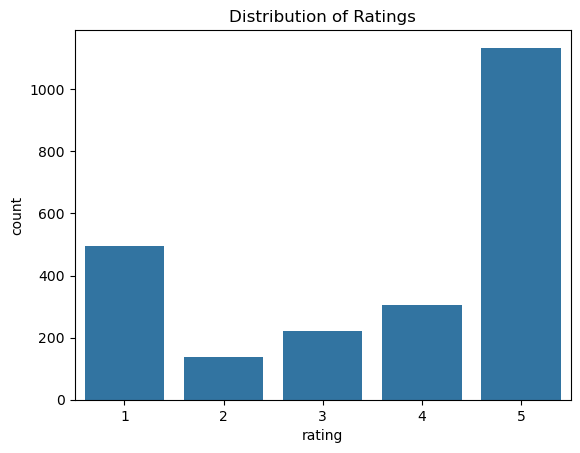

In [98]:
sns.countplot(data=df, x='rating')
plt.title('Distribution of Ratings')
output_dir = "../imgs"
output_file = "distribution_ratings.png"
output_path = os.path.join(output_dir, output_file)
plt.savefig(output_path, bbox_inches='tight') 
plt.show()

#### Sentiment Polarity 

I started off with TextBlob to determine sentiment polarity. I was able to create an arbitrary distribution showing the number of positive, neutral and negative scores among the given dataset. 

**Source:** 
> https://textblob.readthedocs.io/en/dev/

In [99]:
def get_sentiment_polarity(text):
    return TextBlob(text).sentiment.polarity

df['sentiment'] = df['processed_text'].apply(get_sentiment_polarity)

In [100]:
# Assign each review to a specific category based on its sentiment value 
def sentiment_category(polarity):
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

In [101]:
df['sentiment_category'] = df['sentiment'].apply(sentiment_category)

In [102]:
print("Sentiment Category Distribution:")
print(df['sentiment_category'].value_counts())

Sentiment Category Distribution:
sentiment_category
positive    1378
neutral      592
negative     322
Name: count, dtype: int64


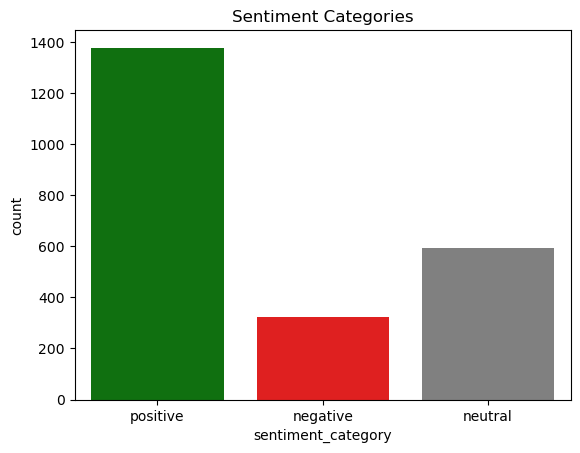

In [103]:
palette = {'positive': 'green', 'neutral': 'gray', 'negative': 'red'}
sns.countplot(data=df, x='sentiment_category', palette=palette, hue = 'sentiment_category')
plt.title('Sentiment Categories')
output_dir = "../imgs"
output_file = "sentiment_categories.png"
output_path = os.path.join(output_dir, output_file)
plt.savefig(output_path, bbox_inches='tight')
plt.show()

In order to further explore sentiment distribution, I looked into VADER. VADER or Valance Aware Dictionary and Sentiment Reasoner is a rule-based sentiment analysis tool specifically tuned for social media and customer reviews (for example, emojis, punctuation, etc). This outputs a compund score that ranges from -1 (negative sentiment) to 1 (positive sentiment). Below, I used polarity_score(x) to return a dictionary of sentiment scores. This applies a sentiment score to each review allowing us to see a clear distribution of negative, neutral and positive reviews. I opted for the pretrained model VADER because it results in quick, interpretable results without me having to manually train the model. 

**Source:**
* https://www.nltk.org/api/nltk.sentiment.vader.html
* https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/#

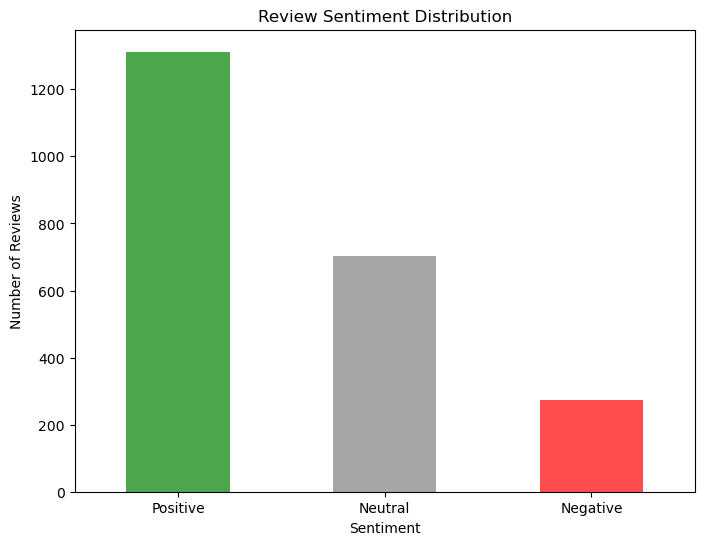

In [104]:
df['processed_text'] = df['processed_text'].fillna("").astype(str)

# Sentiment analysis using VADER
# Initializing SentimentAnalyzer 
analyzer = SentimentIntensityAnalyzer()
df['sentiment_vader'] = df['processed_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df['sentiment_category_vader'] = pd.cut(df['sentiment'], bins=[-1, -0.05, 0.05, 1], labels=['Negative', 'Neutral', 'Positive'])

# Visualize sentiment distribution
sentiment_counts = df['sentiment_category_vader'].value_counts()

plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'gray', 'red'], alpha=0.7)
plt.title('Review Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
output_dir = "../imgs"
output_file = "distribution_ratings_vader.png"
output_path = os.path.join(output_dir, output_file)
plt.savefig(output_path, bbox_inches='tight')
plt.show()

In [105]:
df.head()

,date,title,review,rating,text,processed_text,sentiment,sentiment_category,sentiment_vader,sentiment_category_vader
0,2023-05-21 16:42:24,Much more accessible for blind users than the ...,Up to this point I’ve mostly been using ChatGP...,4,Much more accessible for blind users than the ...,much accessible blind users web version point ...,0.233333,positive,0.9814,Positive
1,2023-07-11 12:24:19,"Much anticipated, wasn’t let down.",I’ve been a user since it’s initial roll out a...,4,"Much anticipated, wasn’t let down. I’ve been a...",much anticipated wasnt let ive user since init...,0.214055,positive,0.9805,Positive
2,2023-05-19 10:16:22,"Almost 5 stars, but… no search function",This app would almost be perfect if it wasn’t ...,4,"Almost 5 stars, but… no search function This a...",almost 5 stars search function app would almos...,0.160632,positive,0.9496,Positive
3,2023-05-27 21:57:27,"4.5 stars, here’s why","I recently downloaded the app and overall, it'...",4,"4.5 stars, here’s why I recently downloaded th...",45 stars heres recently downloaded app overall...,0.286335,positive,0.9932,Positive
4,2023-06-09 07:49:36,"Good, but Siri support would take it to the ne...",I appreciate the devs implementing Siri suppor...,4,"Good, but Siri support would take it to the ne...",good siri support would take next level apprec...,0.171935,positive,0.9739,Positive


In [106]:
df.shape

(2292, 10)

Now, I want to see the features and their average sentiment. If users are talking about a specific feature, how do they feel about it? 

In [107]:
file_path = '../data/chatgpt_cleaned_features.csv'
df_f = pd.read_csv(file_path)

In [108]:
df_f.head()

,date,title,review,rating,processed_reviews,features
0,2023-05-21 16:42:24,Much more accessible for blind users than the ...,Up to this point I’ve mostly been using ChatGP...,4,point ive mostly using chatgpt windows desktop...,"['chatgpt windows desktop', 'google chrome doa..."
1,2023-07-11 12:24:19,"Much anticipated, wasn’t let down.",I’ve been a user since it’s initial roll out a...,4,ive user since initial roll waiting mobile app...,"['initial roll', 'mobile application', 'web ap..."
2,2023-05-19 10:16:22,"Almost 5 stars, but… no search function",This app would almost be perfect if it wasn’t ...,4,app would almost perfect wasnt one little thin...,"['one little thing search function anyone', 's..."
3,2023-05-27 21:57:27,"4.5 stars, here’s why","I recently downloaded the app and overall, it'...",4,recently downloaded app overall great platform...,['recently downloaded app overall great platfo...
4,2023-06-09 07:49:36,"Good, but Siri support would take it to the ne...",I appreciate the devs implementing Siri suppor...,4,appreciate devs implementing siri supportit al...,"['siri supportit', 'usefulness app', 'make que..."


In [109]:
df_f.shape

(2292, 6)

I am just going to concat the two dataframes to create one dataframe with both sentiment and features. 

In [110]:
gpt_df = pd.concat([df, df_f['features']], axis = 1)
gpt_df.head()

,date,title,review,rating,text,processed_text,sentiment,sentiment_category,sentiment_vader,sentiment_category_vader,features
0,2023-05-21 16:42:24,Much more accessible for blind users than the ...,Up to this point I’ve mostly been using ChatGP...,4,Much more accessible for blind users than the ...,much accessible blind users web version point ...,0.233333,positive,0.9814,Positive,"['chatgpt windows desktop', 'google chrome doa..."
1,2023-07-11 12:24:19,"Much anticipated, wasn’t let down.",I’ve been a user since it’s initial roll out a...,4,"Much anticipated, wasn’t let down. I’ve been a...",much anticipated wasnt let ive user since init...,0.214055,positive,0.9805,Positive,"['initial roll', 'mobile application', 'web ap..."
2,2023-05-19 10:16:22,"Almost 5 stars, but… no search function",This app would almost be perfect if it wasn’t ...,4,"Almost 5 stars, but… no search function This a...",almost 5 stars search function app would almos...,0.160632,positive,0.9496,Positive,"['one little thing search function anyone', 's..."
3,2023-05-27 21:57:27,"4.5 stars, here’s why","I recently downloaded the app and overall, it'...",4,"4.5 stars, here’s why I recently downloaded th...",45 stars heres recently downloaded app overall...,0.286335,positive,0.9932,Positive,['recently downloaded app overall great platfo...
4,2023-06-09 07:49:36,"Good, but Siri support would take it to the ne...",I appreciate the devs implementing Siri suppor...,4,"Good, but Siri support would take it to the ne...",good siri support would take next level apprec...,0.171935,positive,0.9739,Positive,"['siri supportit', 'usefulness app', 'make que..."


In [111]:
feature_sentiments = []

for features, sentiment in zip(gpt_df['features'], gpt_df['sentiment_vader']):
    for feature in features:
        feature_sentiments.append((feature, sentiment))

In [112]:
feature_sentiment_df = pd.DataFrame(feature_sentiments, columns=['feature', 'sentiment'])

In [113]:
average_sentiment = feature_sentiment_df.groupby('feature')['sentiment'].mean()

In [114]:
top_features = (
    feature_sentiment_df['feature']
    .value_counts()
    .nlargest(20)
    .index
)

top_features_sentiment = average_sentiment.loc[top_features]

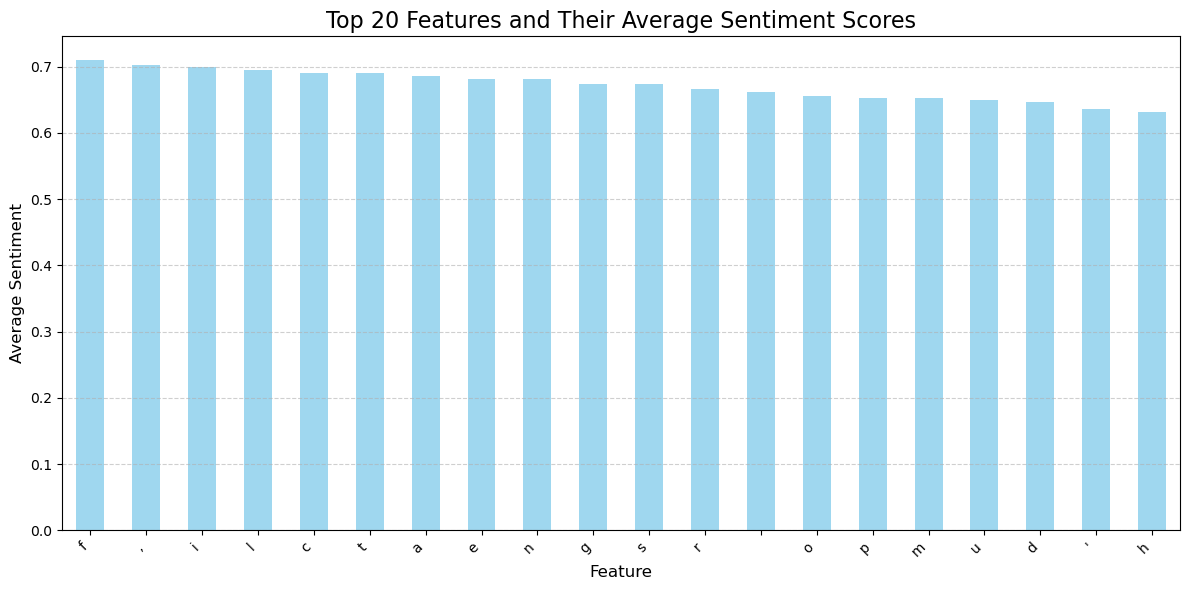

In [115]:
plt.figure(figsize=(12, 6))
top_features_sentiment.sort_values(ascending=False).plot(kind='bar', color='skyblue', alpha=0.8)
plt.title('Top 20 Features and Their Average Sentiment Scores', fontsize=16)
plt.ylabel('Average Sentiment', fontsize=12)
plt.xlabel('Feature', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
output_dir = "../imgs"
output_file = "top_20_features_sentiment.png"
output_path = os.path.join(output_dir, output_file)
plt.savefig(output_path, bbox_inches='tight')
plt.show()

Well, looks like we're having trouble pulling individual features and checking their sentiments. Let's go ahead and create our own arbitrary features and try to group them by sentiment. Even though ideally we would have a model sort through features and their respective sentiments, we are going to create our own list of features and plot out their sentiments.  

In [116]:
features = {
    'interface': ['interface', 'design', 'layout', 'UI'],
    'accuracy': ['accuracy', 'results', 'response', 'output'],
    'performance': ['speed', 'performance', 'lag', 'crash'],
    'cost': ['cost', 'price', 'subscription', 'free']
}

In [117]:
def filter_reviews(review, keywords):
    return any(keyword in review.lower() for keyword in keywords)

for feature, keywords in features.items():
    df[feature] = df['review'].apply(lambda x: filter_reviews(x, keywords))

In [118]:
feature_sentiments = {}
for feature in features.keys():
    feature_data = df[df[feature] == True]
    sentiment_counts = feature_data['sentiment_category'].value_counts()
    feature_sentiments[feature] = sentiment_counts

In [119]:
print("\nFeature-Specific Sentiment Analysis:")
for feature, sentiment_counts in feature_sentiments.items():
    print(f"\n{feature.capitalize()} Sentiments:")
    print(sentiment_counts)


Feature-Specific Sentiment Analysis:

Interface Sentiments:
sentiment_category
positive    146
negative     12
neutral       3
Name: count, dtype: int64

Accuracy Sentiments:
sentiment_category
positive    160
negative     13
neutral       7
Name: count, dtype: int64

Performance Sentiments:
sentiment_category
positive    55
negative     7
neutral      4
Name: count, dtype: int64

Cost Sentiments:
sentiment_category
positive    79
negative    18
neutral     11
Name: count, dtype: int64


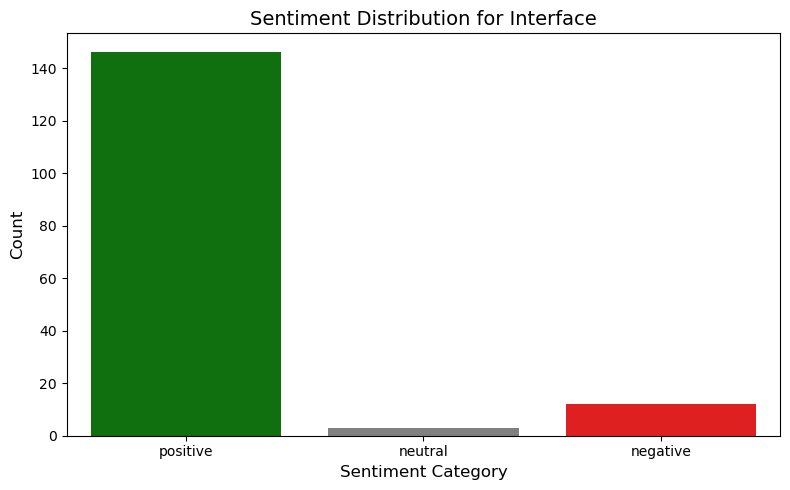

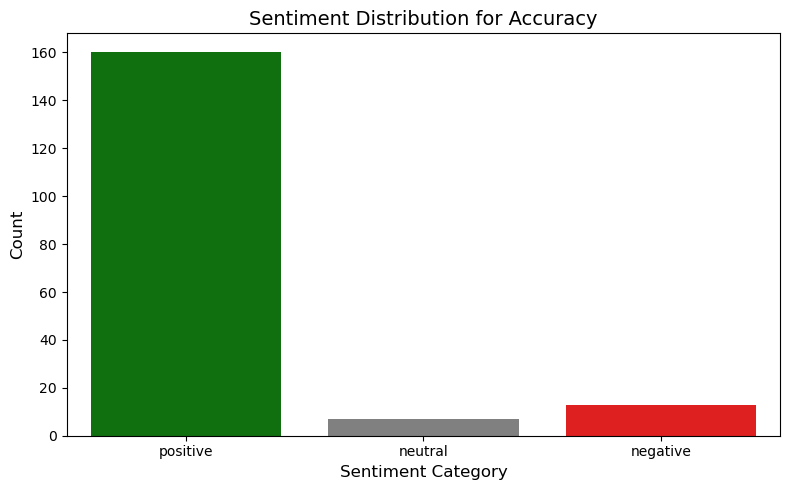

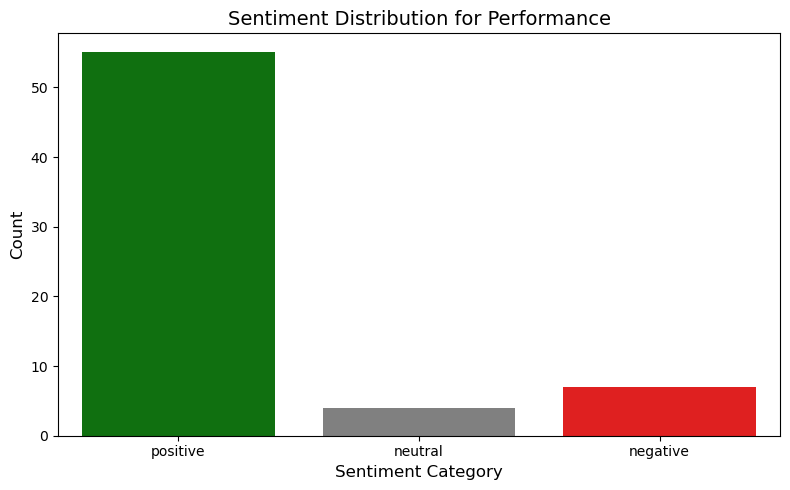

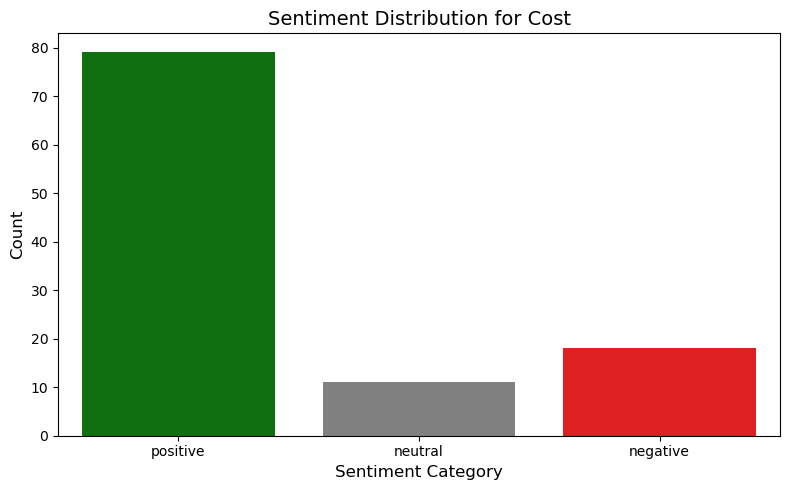

In [120]:
output_file = '../imgs'

palette = {'positive': 'green', 'neutral': 'gray', 'negative': 'red'}

# Go through the features to plot sentiments for each of the reviews
for feature in features.keys():
    feature_data = df[df[feature] == True]
    plt.figure(figsize=(8, 5))  

    # Create the graphs
    sns.countplot(
        data=feature_data,
        x='sentiment_category',
        order=['positive', 'neutral', 'negative'],  
        palette=palette,
        hue = 'sentiment_category'
    )
    plt.title(f'Sentiment Distribution for {feature.capitalize()}', fontsize=14)
    plt.xlabel('Sentiment Category', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(fontsize=10)
    plt.tight_layout()
    output_path = os.path.join(output_file, f"{feature}_sentiment_distribution.png")
    plt.savefig(output_path)
    plt.show()